# In sample results

In [1]:
import sys
sys.path.append('../')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from src.d01_data.dengue_data_api import DengueDataApi
from src.d04_modeling.iohmm import IOHMM

In [2]:
import os
os.chdir('../src')
os.getcwd()

'/Users/juan/Documents/GitHub/cobs10-dengai/src'

In [3]:
# plt.rcParams['font.size'] = '22'
# plt.rcParams['xtick.labelsize'] = '22'
# plt.rcParams['ytick.labelsize'] = '22'
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = 'TeX Gyre Heros'

In [4]:
dda = DengueDataApi()
x_train, x_validate, y_train, y_validate = dda.split_data(random=False)
cities = y_train.index.get_level_values('city').unique()
run_static = True
city_dummy = False
no_glm = False
num_components = 4 if run_static else 3
num_states = 3
run_static = True if no_glm else run_static

In [5]:
from src.d04_modeling.dynamic_factor_model import DynamicFactorModel
if not run_static:
    dfm_model = DynamicFactorModel(x_train.copy(), y_train.copy(), factors=num_components, factor_orders=1, idiosyncratic_ar1=True)
    dfm_model.fit()

    z_train, y_train = dfm_model.get_filtered_factors(x_train.copy(), y_train.copy())
    z_validate, y_validate = dfm_model.get_filtered_factors(x_validate.copy(), y_validate.copy())

In [6]:
y_train

city  year  week_start_date
iq    2000  2000-07-01         0
            2000-07-08         0
            2000-07-15         0
            2000-07-22         0
            2000-07-29         0
                              ..
sj    2002  2002-11-26         5
            2002-12-03         5
            2002-12-10         9
            2002-12-17         3
            2002-12-24         6
Name: total_cases, Length: 997, dtype: int64

In [7]:
from src.d04_modeling.arx import ARX
if not run_static:
    arx_model = ARX(x_train=z_train.copy(), y_train=y_train.copy(), p={'iq': 2, 'sj': 3}, d=1)
    arx_model.fit()
    y_train_hat = []
    y_validate_hat = []
    for city in arx_model.get_cities():
        # print(city)
        y_train_hat += [arx_model.predict(city, z_train.copy())]
        y_validate_hat += [arx_model.predict(city, z_validate.copy())]
    y_train_hat = pd.concat(y_train_hat, axis=0, ignore_index=True)
    y_validate_hat = pd.concat(y_validate_hat, axis=0, ignore_index=True)
    mask = np.isnan(y_train).values
    y_train.loc[mask] = y_train_hat.loc[mask].round().values
    mask = np.isnan(y_validate).values
    y_validate.loc[mask] = y_validate_hat.loc[mask].round().values

    # z_train['bias'] = 1.
    # z_validate['bias'] = 1.

In [8]:
if run_static:
    num_components = 4
    z_train, z_validate, pct_var, factor_loading = dda.get_pca(x_train.copy(), x_validate.copy(), num_components=num_components)
    # z_train['bias'] = 1.
    # z_validate['bias'] = 1.

In [9]:
pct_var

0.9870667571104913

In [10]:
factor_loading

,pc0,pc1,pc2,pc3
ndvi_ne,0.350075,0.035959,0.019416,-0.181143
ndvi_nw,0.317698,0.036133,0.031914,-0.197938
ndvi_se,0.310917,0.022407,0.196429,-0.519344
ndvi_sw,0.341333,0.022323,0.132239,-0.456451
reanalysis_air_temp_k,-0.151136,-0.321800,0.443176,0.004499
reanalysis_avg_temp_k,0.025221,-0.345773,0.479385,0.140652
reanalysis_dew_point_temp_k,0.024458,-0.503374,-0.061126,-0.056482
reanalysis_max_air_temp_k,0.395046,-0.101788,0.219253,0.376409
reanalysis_min_air_temp_k,-0.357949,-0.242039,0.121720,-0.292985
reanalysis_precip_amt_kg_per_m2,0.092295,-0.310775,-0.404550,-0.039195


In [11]:
if city_dummy:
    z_validate['sj'] = 0.
    z_validate.at[('sj', slice(None), slice(None)), 'sj'] = 1.
    z_train['sj'] = 0.
    z_train.at[('sj', slice(None), slice(None)), 'sj'] = 1.
if no_glm:
    columns2drop = z_train.columns[:num_components]
    z_train.drop(columns=columns2drop, inplace=True)
    z_validate.drop(columns=columns2drop, inplace=True)
print(z_train.head())
print(z_train.tail())

                                pc0       pc1       pc2       pc3
city year week_start_date                                        
iq   2000 2000-07-01       2.732341  0.611302 -0.901929 -0.265362
          2000-07-08       3.480752  0.540752 -1.431484  0.270606
          2000-07-15       1.566949  0.338550 -2.809499  0.792046
          2000-07-22       2.220927  4.012572 -2.110429  0.498261
          2000-07-29       3.877287  1.994249 -1.082553 -0.424317
                                pc0       pc1       pc2       pc3
city year week_start_date                                        
sj   2002 2002-11-26      -1.155444 -1.029509  1.330123 -1.257517
          2002-12-03      -2.536104 -0.038720  2.234666 -0.525085
          2002-12-10      -3.047320  0.146650  1.505943  0.063243
          2002-12-17      -2.610423  0.715169  1.230929 -0.049095
          2002-12-24      -2.299045  0.620086  0.015164  0.069080


In [12]:
print("np.isnan(z): ", np.isnan(z_train).any().any())
print("np.isnan(y): ", np.isnan(y_train).any().any())

np.isnan(z):  False
np.isnan(y):  False


Solving
[iter   0] Loss: -5324.6112
Done


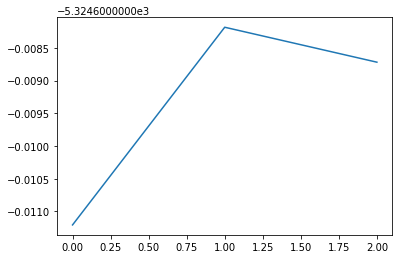

In [13]:
model = IOHMM(num_states=num_states, num_features=z_train.shape[1], load=True)

event_data_train = model.format_event_data(z_train.droplevel('year'), 
                                           y_train.droplevel('year'))
event_data_test = model.format_event_data(z_validate.droplevel('year'),
                                          y_validate.droplevel('year'))
# event_data_train = [event_data_train[1]]
# event_data_test = [event_data_test[1]]
lls = model.fit(event_data=event_data_train, save=True, num_iterations=400)
plt.plot(lls)
plt.show()

In [14]:
output_viterbi, output_network, most_likely_states, expectations, marginal_ll = model.predict(event_data_train)

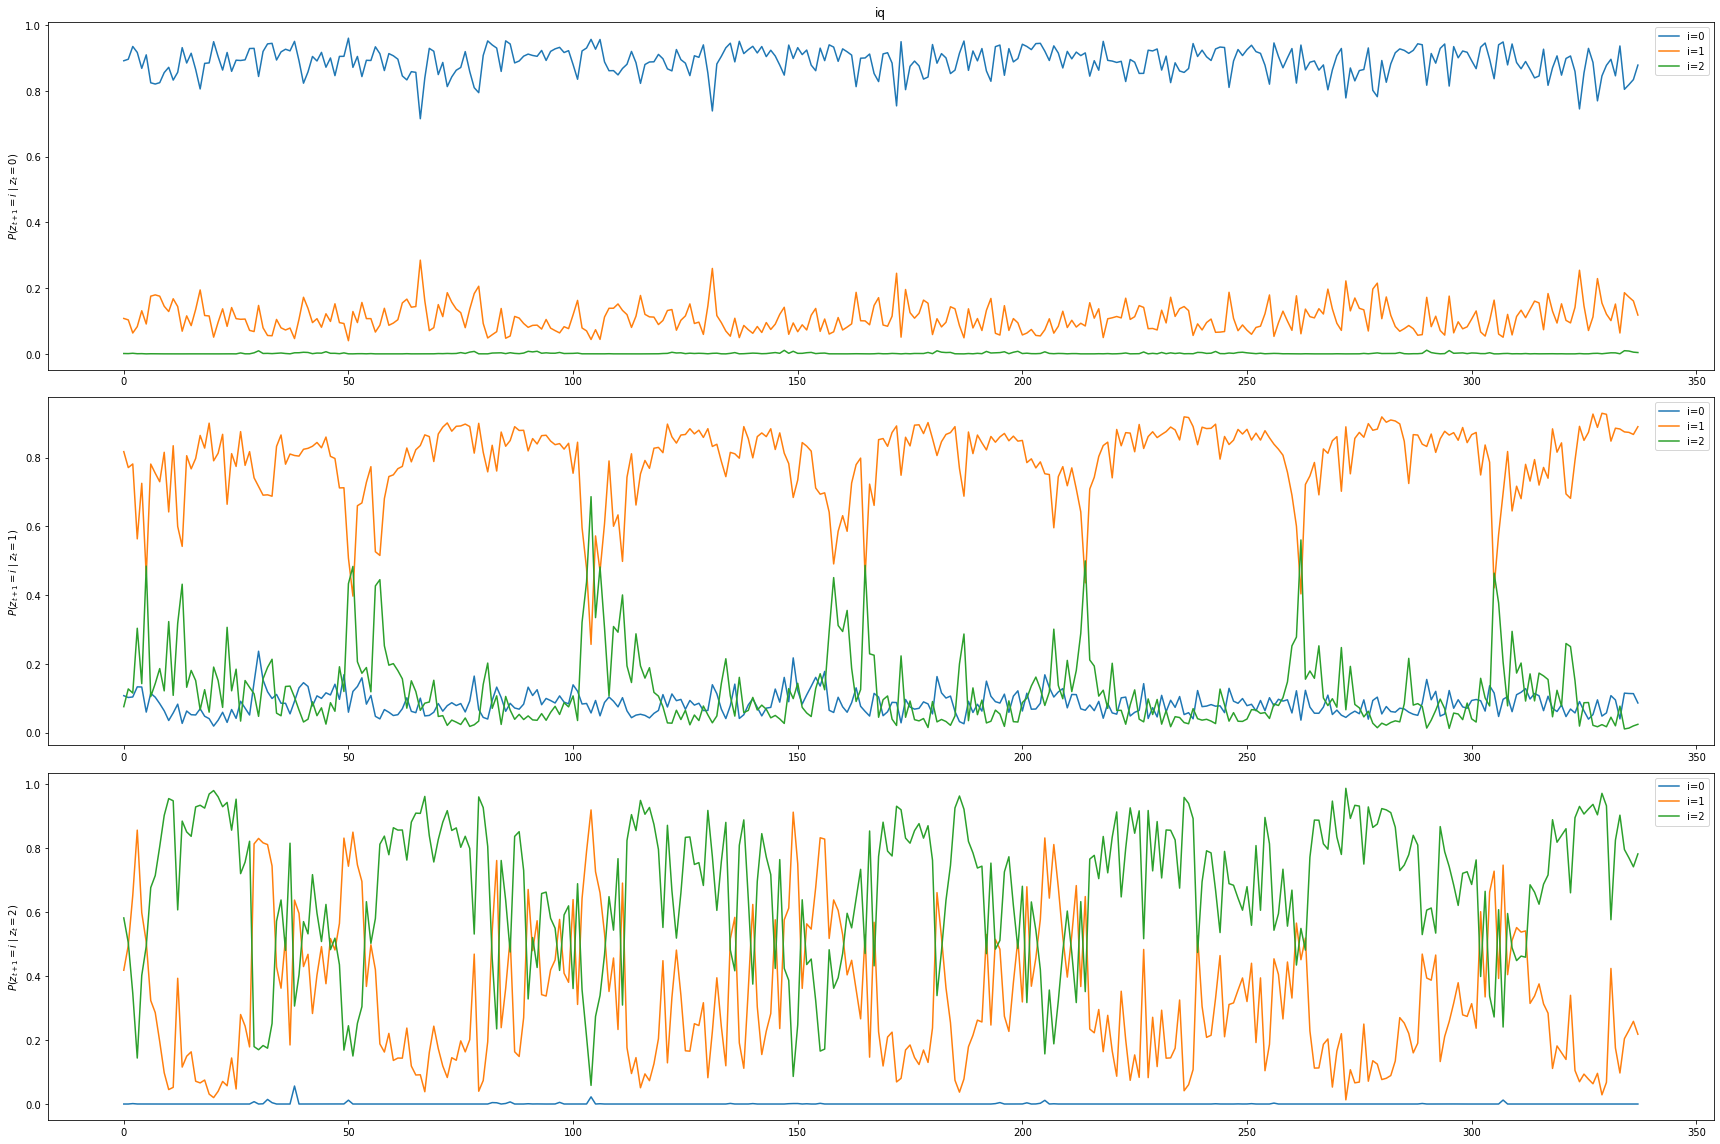

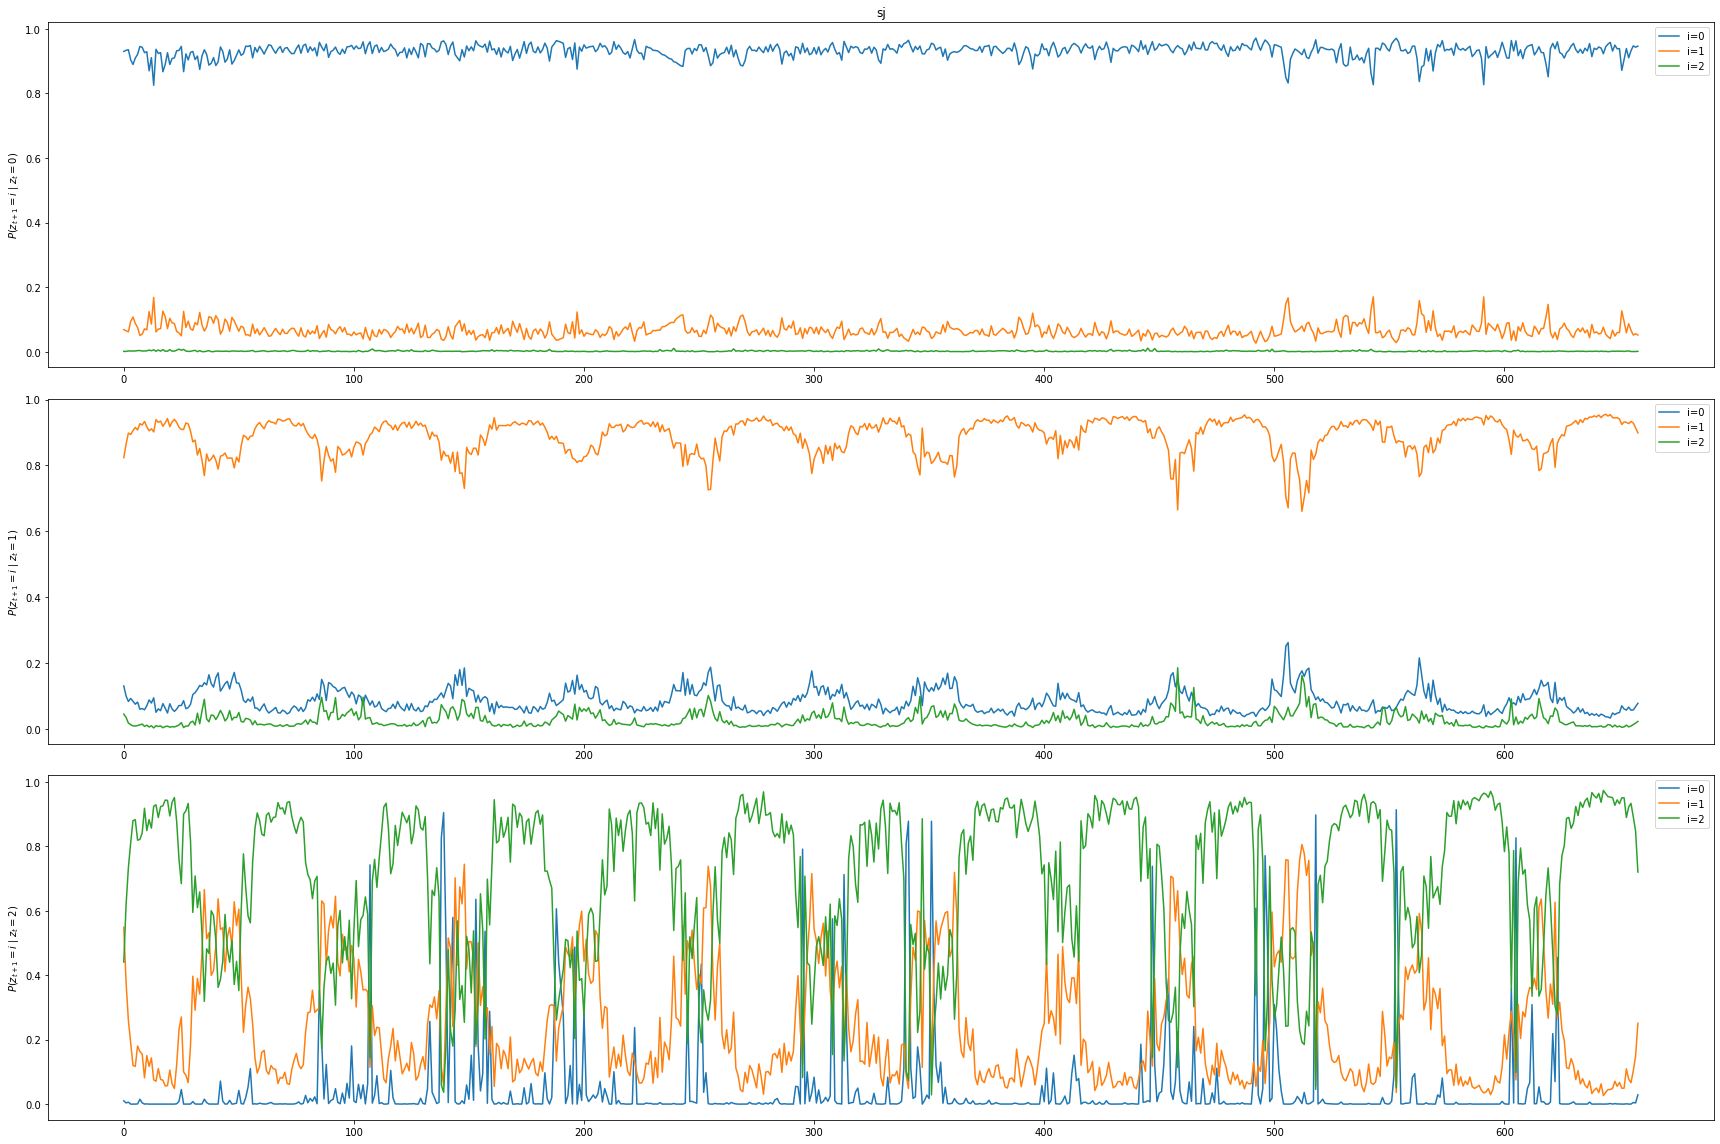

In [15]:
for p in range(len(event_data_train)):
    fig, ax = plt.subplots(nrows=num_states, figsize=(24, 16))
    input_observations, output_observations = event_data_train[p]
    log_psi = torch.squeeze(model.get_log_psi(input_observations)).detach().numpy()
    ax[0].set_title(cities[p])
    for j in range(num_states):
        for i in range(num_states):
            ax[j].plot(np.exp(log_psi[j, :, i]), label="i=%i" % i)
            ax[j].set_ylabel("$P(z_{t+1}=i\mid z_{t}=%i)$" % j)
            ax[j].legend()
    plt.tight_layout()
    plt.plot()

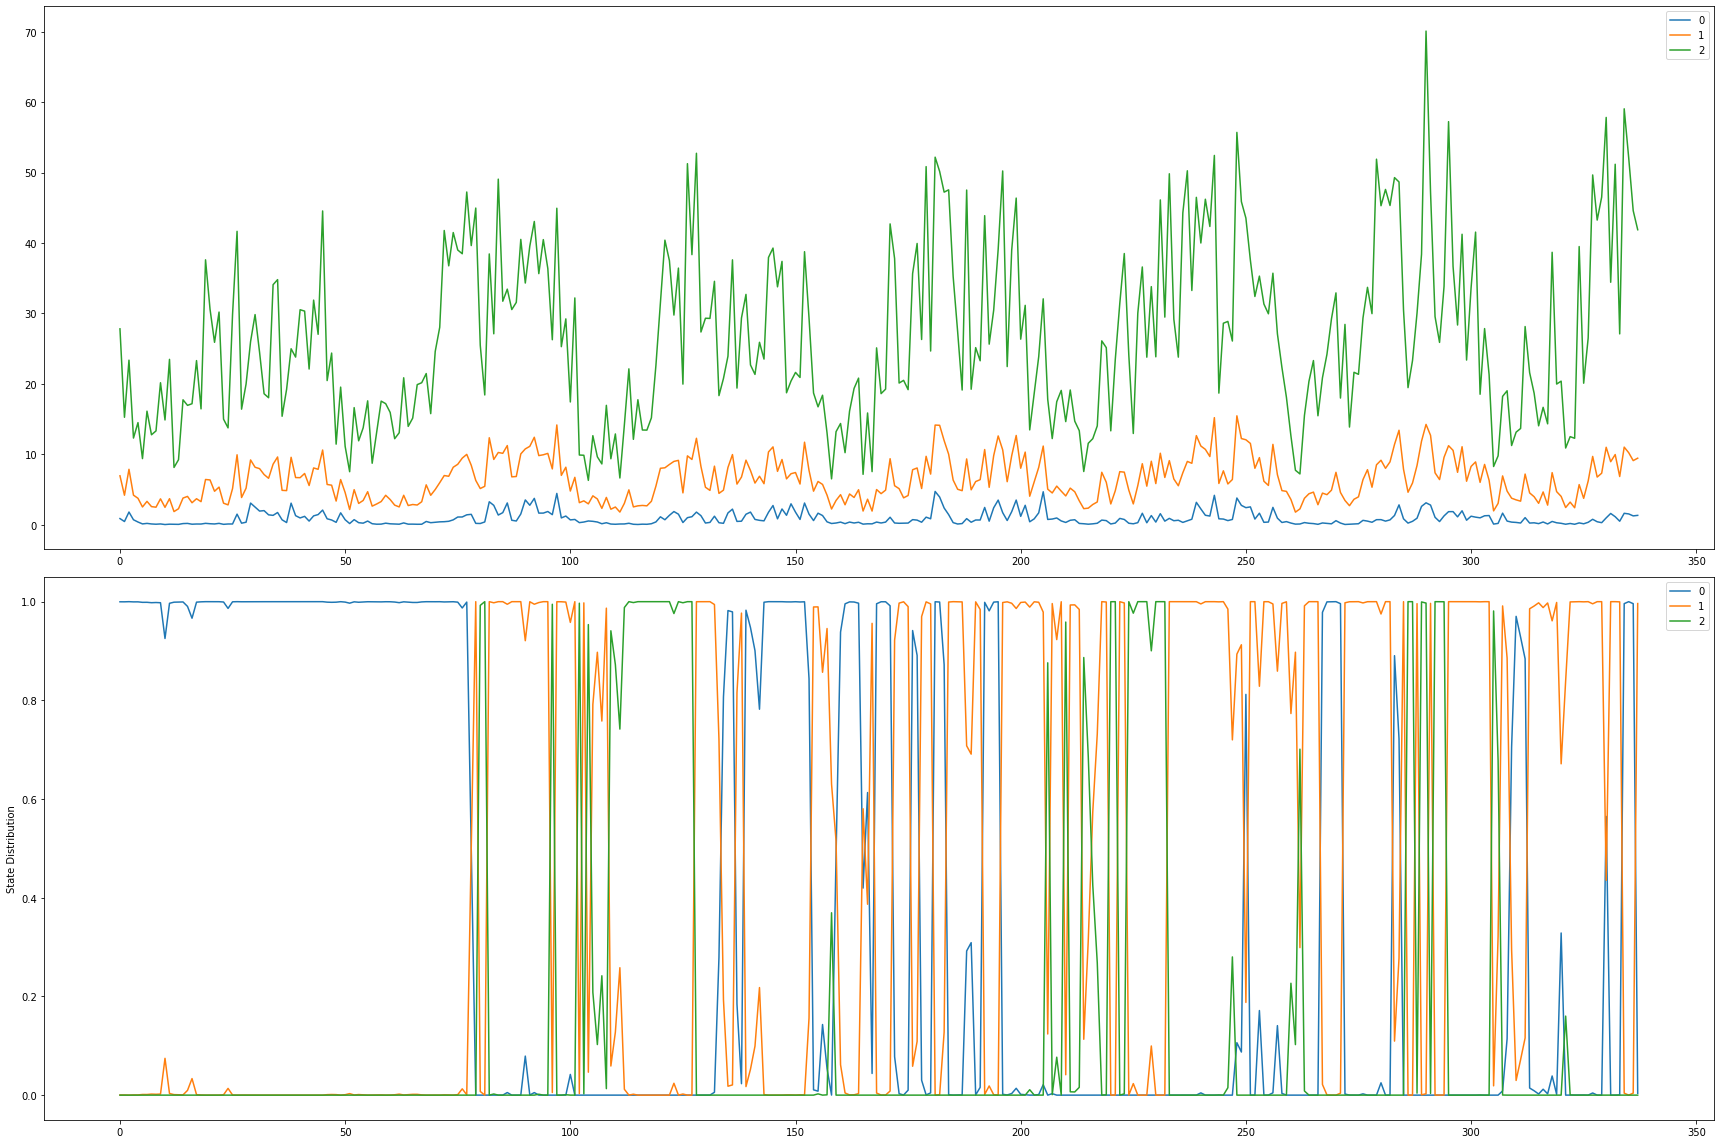

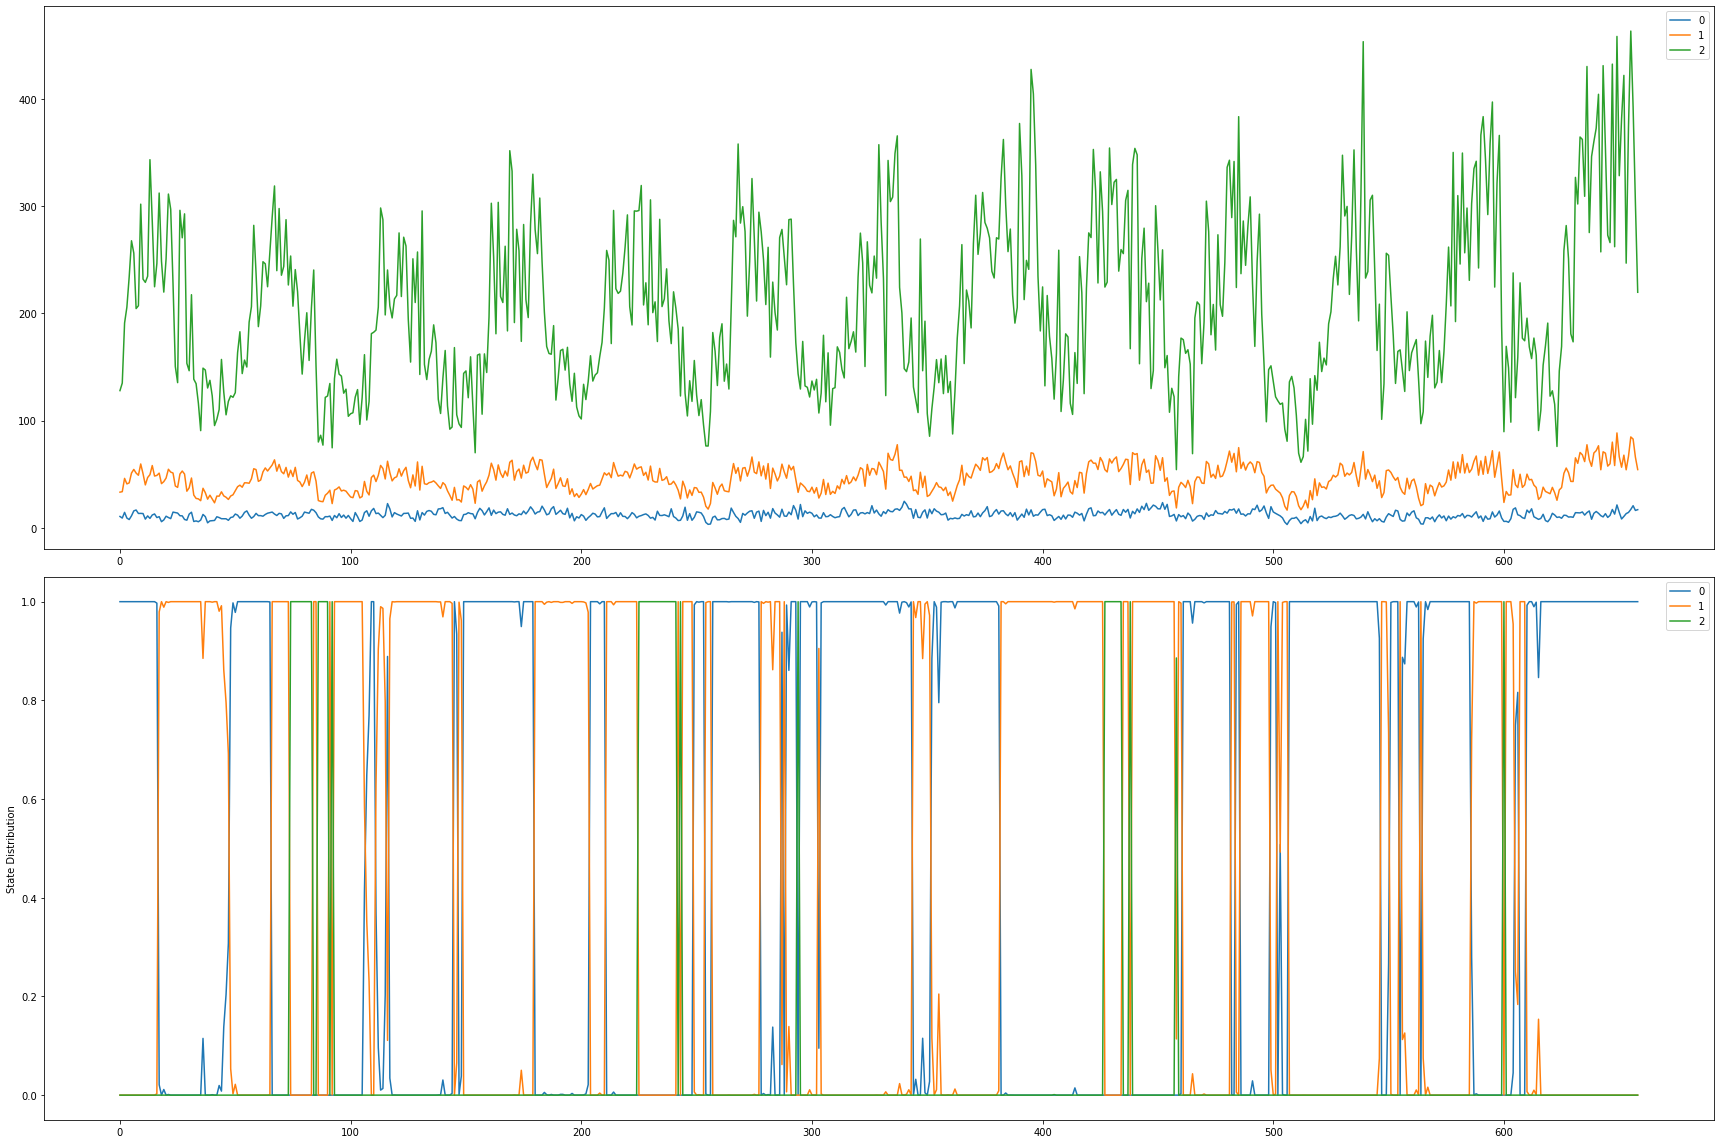

In [16]:
for p in range(len(event_data_train)):
    fig, ax = plt.subplots(nrows=2, figsize=(24, 16))
    input_observations, output_observations = event_data_train[p]
    y = output_observations.detach().numpy()
    y_hat = output_network[p].T
    # ax[0].plot(y, label='obs', color='gray')
    for j in range(num_states):
        ax[0].plot(y_hat[:, j], label=j)
        ax[0].legend()
        ax[1].plot(expectations[p].detach().numpy()[:, j], label=j)
        ax[1].set_ylabel('State Distribution')
        ax[1].legend()
    plt.tight_layout()
    # plt.savefig('forecast_%s.png' % cities[p])
    plt.plot()

[iq] Prediction MAE: 8.2647
[sj] Prediction MAE: 42.5501


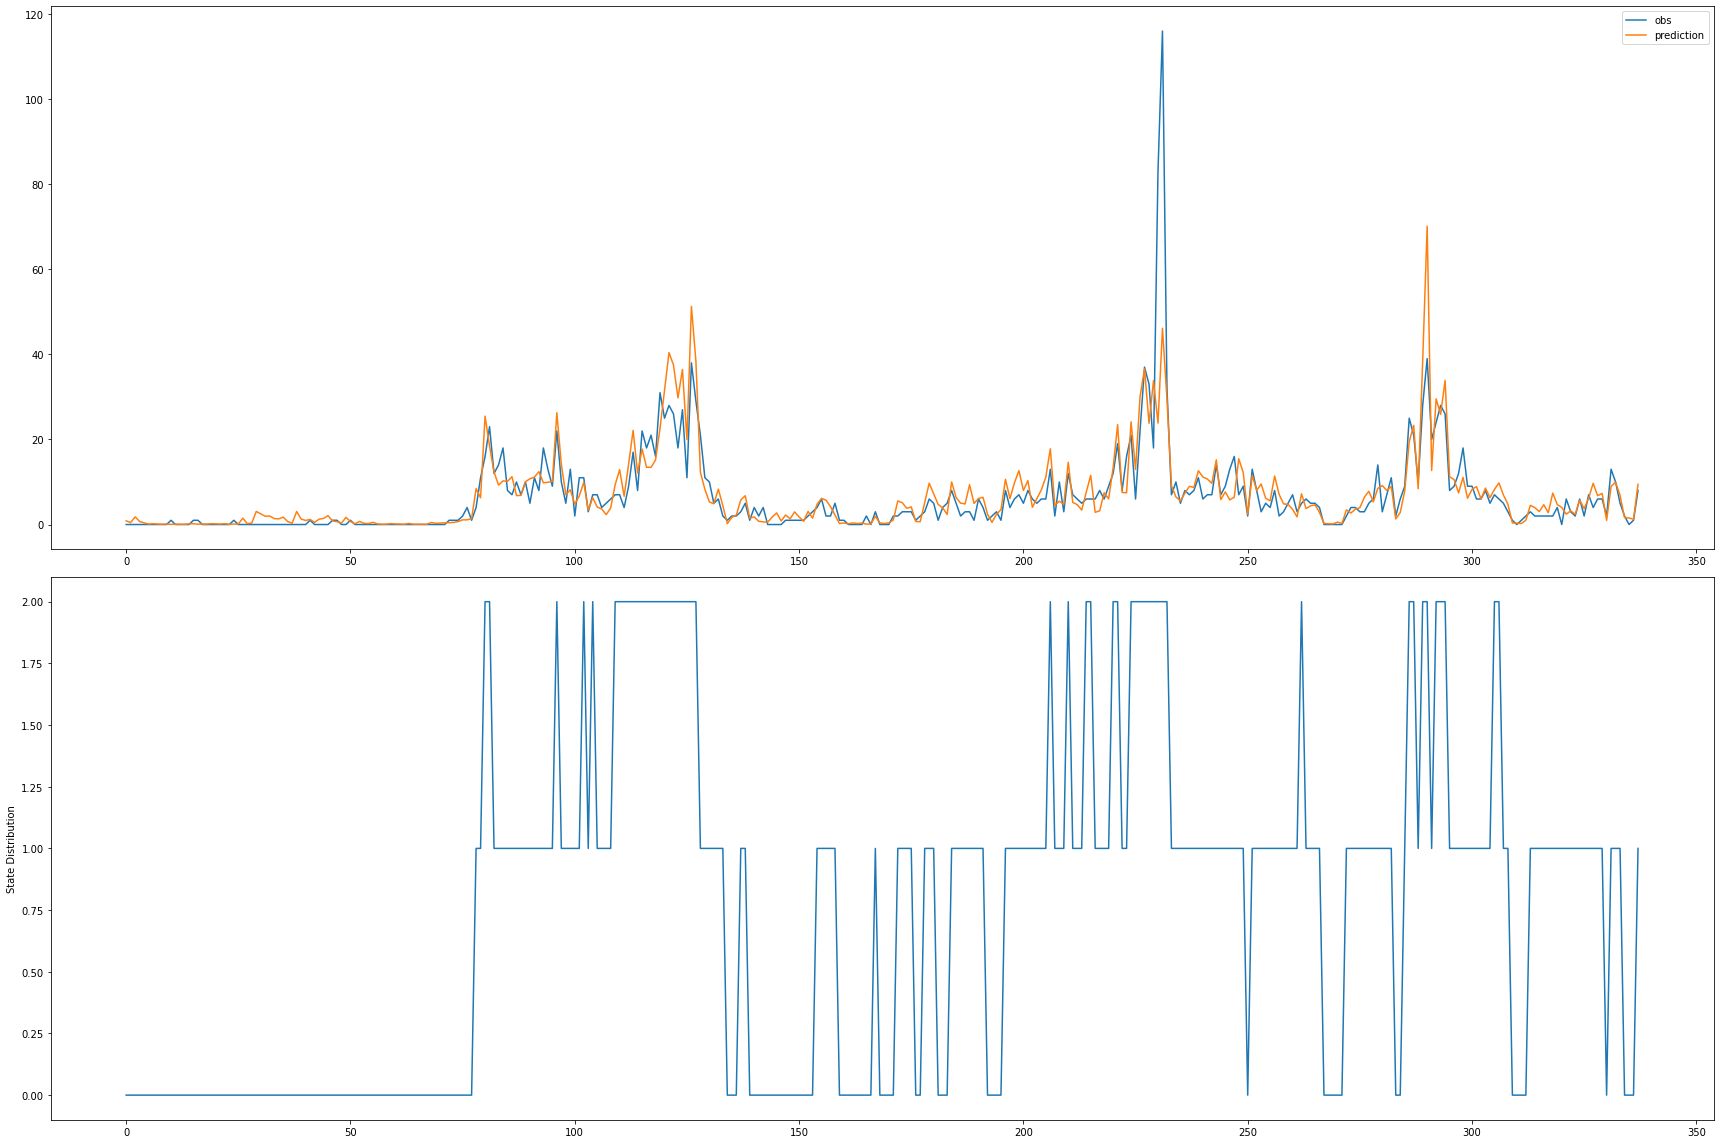

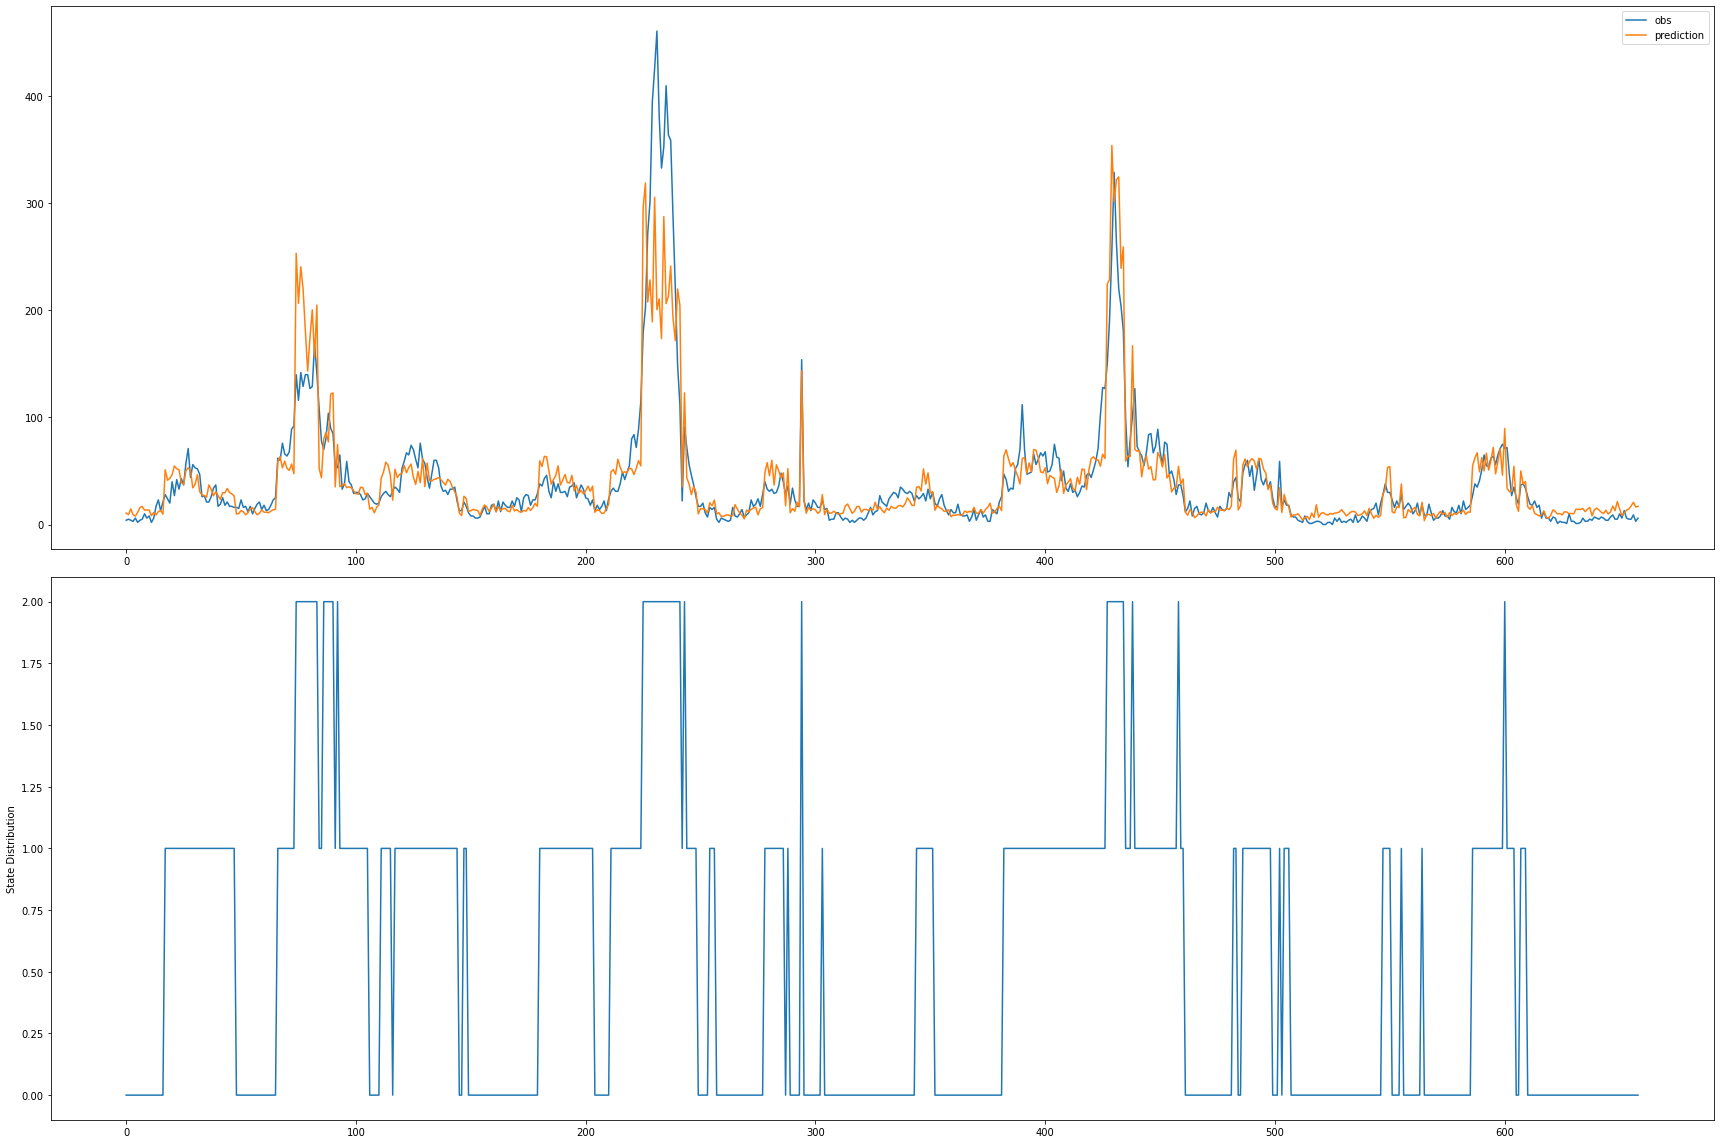

In [17]:
for p in range(len(event_data_train)):
    fig, ax = plt.subplots(nrows=2, figsize=(24, 16))
    input_observations, output_observations = event_data_train[p]
    y = output_observations.detach().numpy()
    y_hat = output_viterbi[p]
    ax[0].plot(y, label='obs')
    ax[0].plot(y_hat, label='prediction')
    ax[0].legend()
    ax[1].plot(np.array(most_likely_states[p]))
    ax[1].set_ylabel('State Distribution')
    fig.tight_layout()
    fig.savefig('iohmm_viterbi_%s.png' % cities[p])
    print("[%s] Prediction MAE: %.4f" % (cities[p], np.abs(y-y_hat).mean()))


# Out of sample results

In [22]:
event_data_test = model.format_event_data(z_validate.droplevel('year'), y_validate.droplevel('year'))
forecasts, states_prob = model.forecast(event_data_train, event_data_test)

Sampling..................Done
Sampling...........................Done


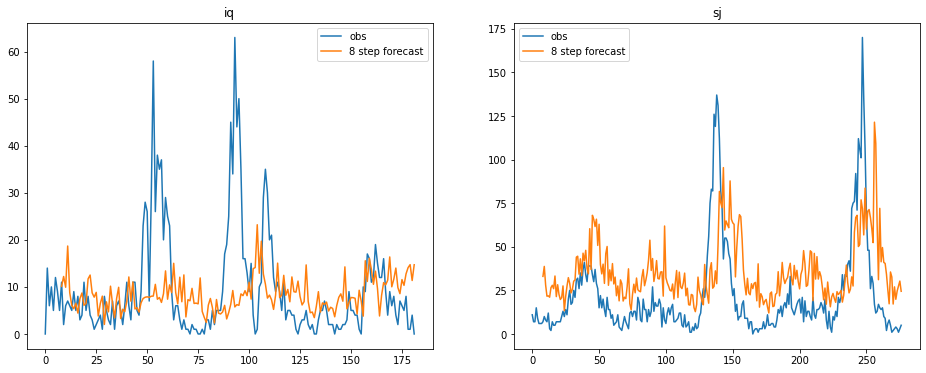

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
for p in range(2):
    input_observations, output_observations = event_data_test[p]
    y = output_observations.detach().numpy().flatten()
    ax[p].plot(y, label='obs')
    ax[p].plot(forecasts[p]['map'], label='8 step forecast')
    ax[p].legend()
    ax[p].set_title(cities[p])

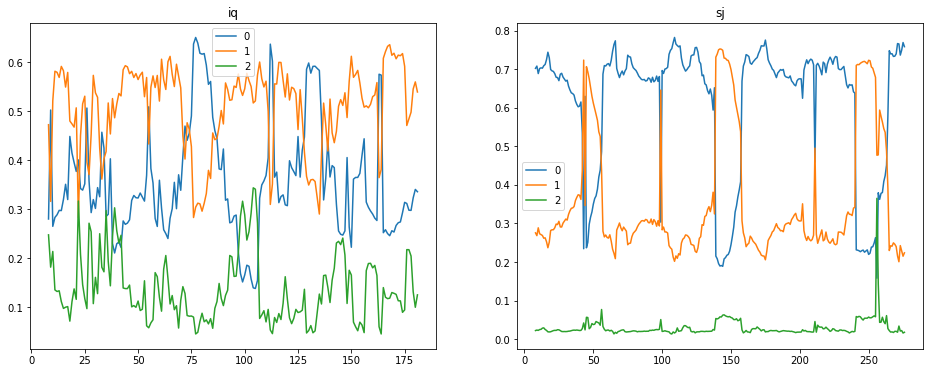

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
for p in range(2):
    for k in range(model.num_states):
        ax[p].plot(states_prob[p][k], label=k)
    ax[p].legend()
    ax[p].set_title(cities[p])

[iq] Forecast MAE: 7.1954
[sj] Forecast MAE: 16.0074


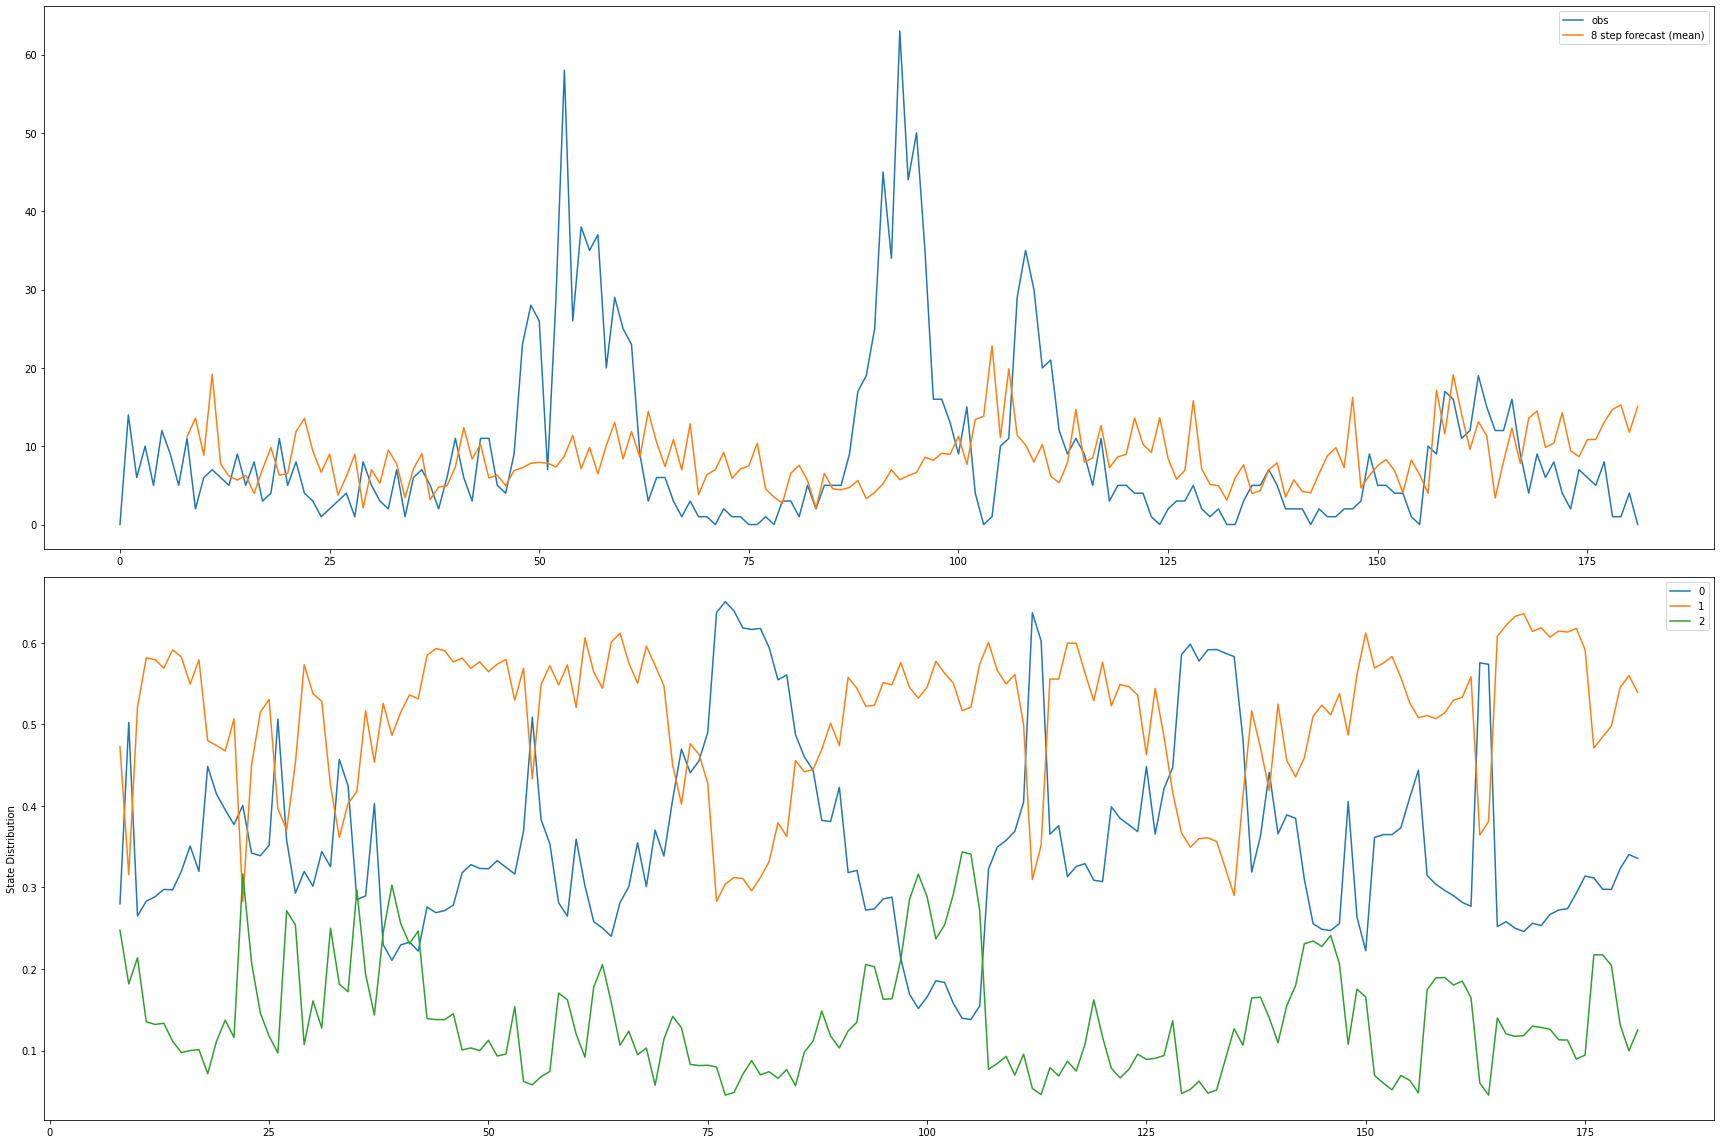

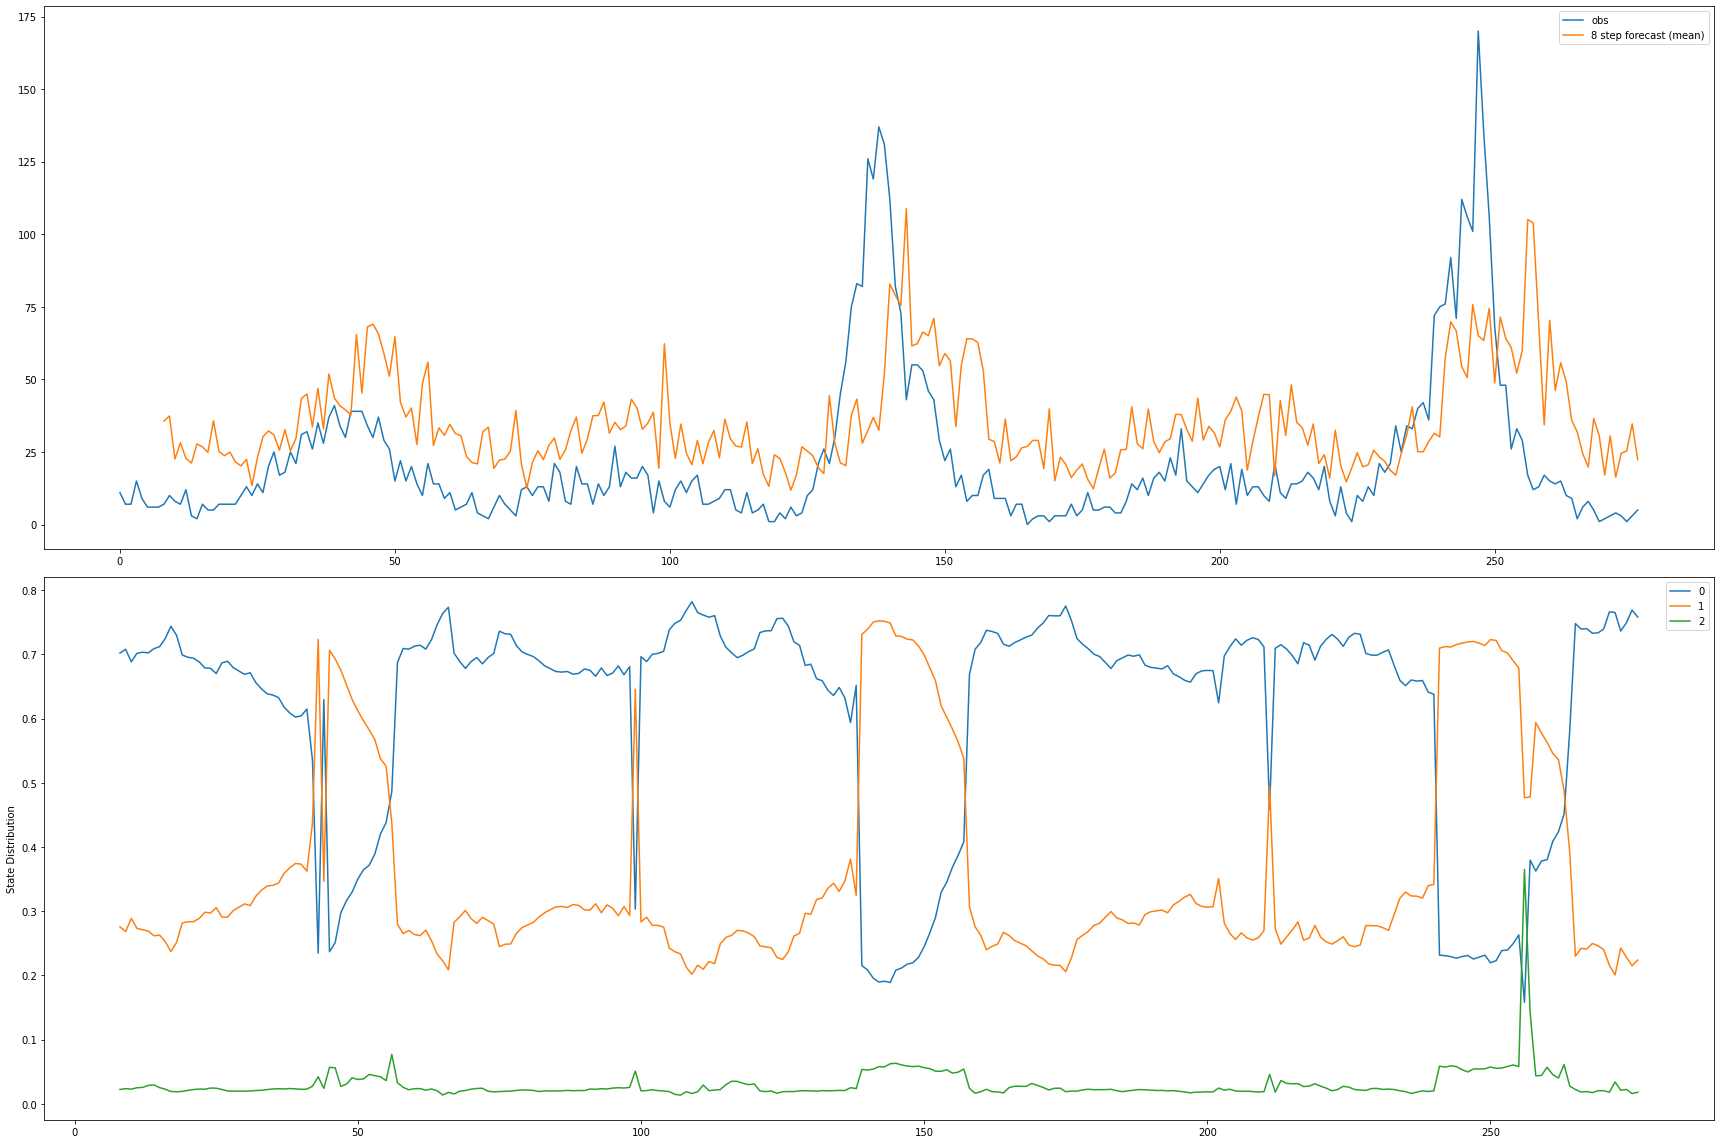

In [20]:
t0 = 0
for p in range(len(event_data_train)):
    fig, ax = plt.subplots(nrows=2, figsize=(24, 16))
    input_observations, output_observations = event_data_test[p]
    y = output_observations.detach().numpy().flatten()
    t = np.arange(y.shape[0])
    ax[0].plot(y, label='obs')
    ax[0].plot(forecasts[p]['map'], label='8 step forecast (mean)')
    # ax[0].plot(forecasts[p]['median'], label='8 step forecast (median)')
    alpha = 0.05
    # ax[0].fill_between(t, forecasts[p]['lower'],
    #                 forecasts[p]['upper'],
    #                facecolor='orange', alpha=0.5)
    most_likely_states = np.argmax(states_prob[p].values, axis=1)
    ax[0].legend()
    for k in range(model.num_states):
        ax[1].plot(states_prob[p][k], label=k)
    ax[1].legend()
    ax[1].set_ylabel('State Distribution')
    plt.tight_layout()
    plt.savefig('iohmm_forecast_%s.png' % cities[p])
    print("[%s] Forecast MAE: %.4f" % (cities[p], np.abs(forecasts[p]['median']-y).mean()))